In [2]:
import os
from cil.io import ZEISSDataReader
from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.plugins.astra import ProjectionOperator, FBP
from cil.optimisation.functions import LeastSquares, L2NormSquared
from cil.utilities.display import show2D, show_geometry
from cil.optimisation.algorithms import FISTA, ISTA
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.utilities import RandomSampling, SequentialSampling
from cil.optimisation.functions import SAGAFunction
from cil.utilities import dataexample

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

### Read Steel-wire data

In [3]:
data = dataexample.SYNCHROTRON_PARALLEL_BEAM_DATA.get()
data_raw20 = data.get_slice(vertical=20)
scale = data_raw20.sum()/data_raw20.size
data /= scale
data.log(out=data)
data *= -1
data = CentreOfRotationCorrector.xcorrelation(slice_index='centre')(data)
data = Slicer(roi={'vertical': (1, None), 'angle':(0,90,1)})(data)
data.reorder('astra')

### Note

The number of projection angles for the `SYNCHROTRON_PARALLEL_BEAM_DATA` are 91 but we do not consider the last one. However, the splitting below can work for non-constant `batch_size`.

In [4]:
ag = data.geometry
ig = ag.get_ImageGeometry()

In [5]:
print("ImageGeometry = {}".format((ig.shape, ig.dimension_labels)))
print("AcquisitionGeometry = {}".format((ag.shape, ag.dimension_labels)))

ImageGeometry = ((134, 160, 160), ('vertical', 'horizontal_y', 'horizontal_x'))
AcquisitionGeometry = ((134, 90, 160), ('vertical', 'angle', 'horizontal'))


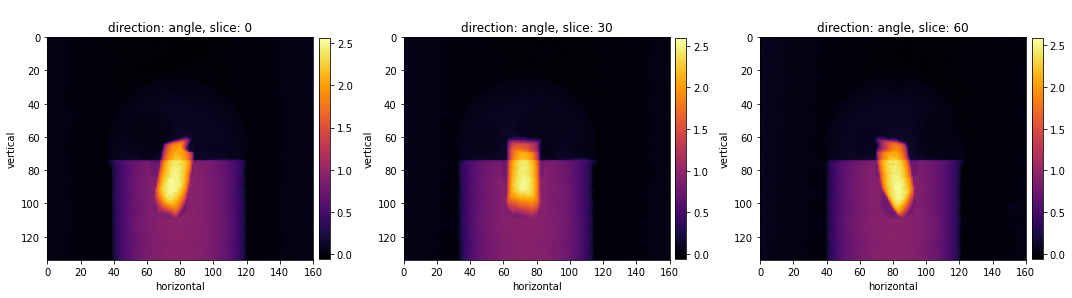

In [6]:
show2D(data, slice_list=[('angle',0), ('angle', 30), ('angle',60)], \
         num_cols=3, size=(15,15), origin='upper-left', cmap="inferno")

# Sampling strategies for AcquisitionData

- We use the `RandomSampling` and `SequentialSampling` classes to split our `AcquisitionData` into a number of chunks/subsets with `batch_size`. `batch_size` can be non-constant.

## SequentialSplitting

- For AcquisitionData with `len(ag.angles)` we can split it into chunks/subsets with `step_size`.

    - `step_size = 1`, `batch_size=10`
    - Chunk 0 : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    - Chunk 1 : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    
    - `step_size = 10`, `batch_size=9`
    
    - Chunk 0 : [0, 10, 20, 30, 40, 50, 60, 70, 80]
    - Chunk 1 : [1, 11, 21, 31, 41, 51, 61, 71, 81]
   

### step_size = 1, batch_size = 10

In [7]:
num_angles = len(ag.angles)

In [8]:
batch_size = 10
step_size = 1
sequential_splitting = SequentialSampling(num_angles, step_size = step_size, batch_size=batch_size)

In [9]:
print("Number of chunks/subsets = {}".format(sequential_splitting.num_batches))

for i,k in enumerate(sequential_splitting.partition_list):
    print("Chunk {} : {}\n".format(i,k))
    
list_ad_chunks_seq_split = data.split_to_chunks(sequential_splitting)

for i,k in enumerate(list_ad_chunks_seq_split):
    print("Chunk {} : Angles used = {}\n".format(i,list(k.geometry.angles)))


Number of chunks/subsets = 9
Chunk 0 : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Chunk 1 : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Chunk 2 : [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

Chunk 3 : [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

Chunk 4 : [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

Chunk 5 : [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

Chunk 6 : [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]

Chunk 7 : [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]

Chunk 8 : [80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

Chunk 0 : Angles used = [-88.2, -86.2, -84.2001, -82.2, -80.2, -78.2, -76.1999, -74.2, -72.1999, -70.2]

Chunk 1 : Angles used = [-68.2, -66.2, -64.1999, -62.2, -60.2, -58.2, -56.2, -54.2, -52.2, -50.2]

Chunk 2 : Angles used = [-48.2, -46.2, -44.1999, -42.1999, -40.2, -38.2, -36.1997, -34.2, -32.2, -30.2]

Chunk 3 : Angles used = [-28.2, -26.2, -24.2, -22.2, -20.2, -18.2, -16.2, -14.2, -12.2, -10.1999]

Chunk 4 : Angles used = [-8.2, -6.2, -4.1999, -2.2, -0.2, 1.8, 3.8001, 5.8, 7.8, 9.8]

Chunk 5 : Angles u

### Show chunks

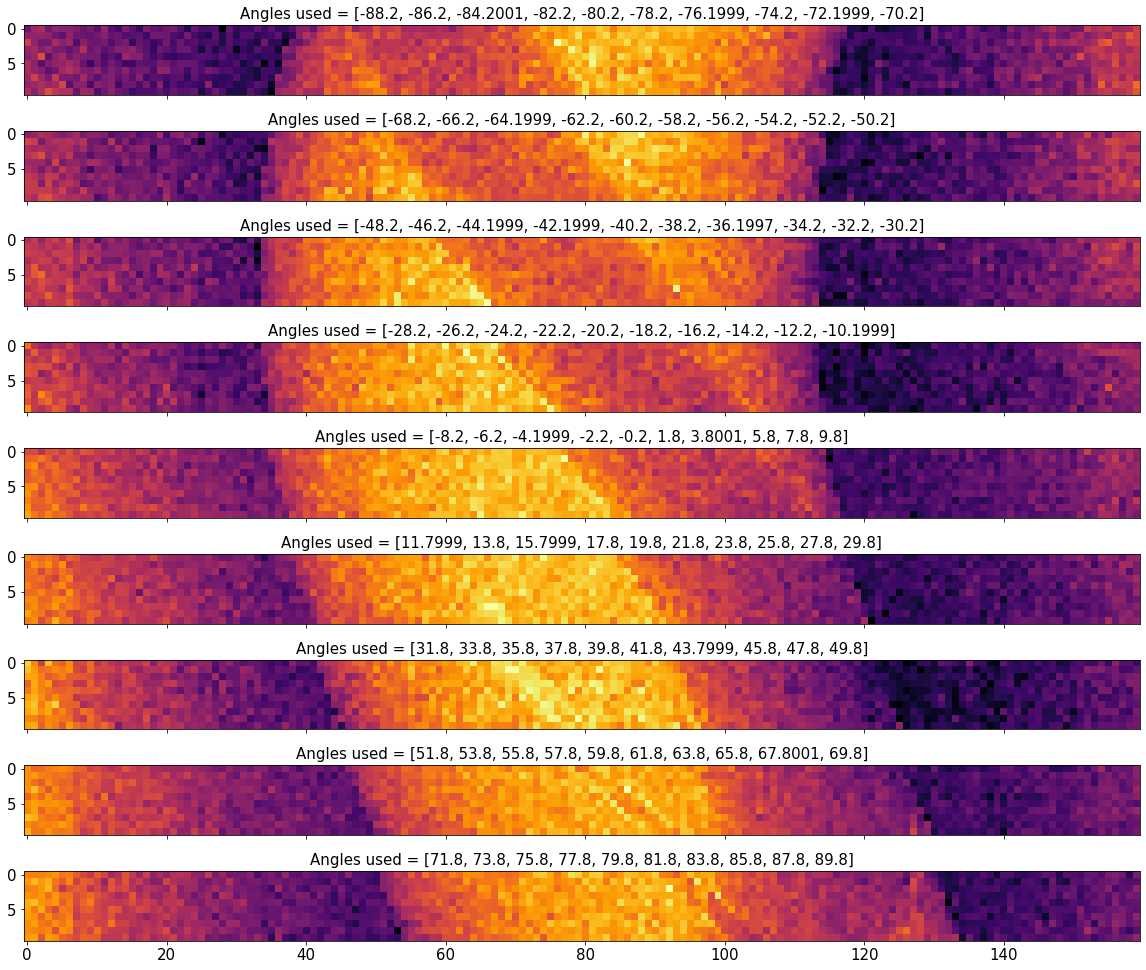

In [10]:
slice_ind = 50

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 20)) 
grid = AxesGrid(fig, 111,
                nrows_ncols=(sequential_splitting.num_batches, 1),
                axes_pad=0.5
                )
k = 0
for ax in grid:    
    ax.imshow(list_ad_chunks_seq_split[k].array[slice_ind], cmap="inferno")
    ax.set_title("Angles used = {}".format(list(list_ad_chunks_seq_split[k].geometry.angles)),fontsize=15)    
    k+=1    
plt.show()


### step_size = 10, batch_size = 9

In [11]:
batch_size = 9
step_size = 10
sequential_splitting = SequentialSampling(num_angles, step_size = step_size, batch_size=batch_size)

In [12]:
print("Number of chunks/subsets = {}".format(sequential_splitting.num_batches))

for i,k in enumerate(sequential_splitting.partition_list):
    print("Chunk {} : {}\n".format(i,k))
    
list_ad_chunks_seq_split = data.split_to_chunks(sequential_splitting)

for i,k in enumerate(list_ad_chunks_seq_split):
    print("Chunk {} : Angles used = {}\n".format(i,list(k.geometry.angles)))


Number of chunks/subsets = 10
Chunk 0 : [0, 10, 20, 30, 40, 50, 60, 70, 80]

Chunk 1 : [1, 11, 21, 31, 41, 51, 61, 71, 81]

Chunk 2 : [2, 12, 22, 32, 42, 52, 62, 72, 82]

Chunk 3 : [3, 13, 23, 33, 43, 53, 63, 73, 83]

Chunk 4 : [4, 14, 24, 34, 44, 54, 64, 74, 84]

Chunk 5 : [5, 15, 25, 35, 45, 55, 65, 75, 85]

Chunk 6 : [6, 16, 26, 36, 46, 56, 66, 76, 86]

Chunk 7 : [7, 17, 27, 37, 47, 57, 67, 77, 87]

Chunk 8 : [8, 18, 28, 38, 48, 58, 68, 78, 88]

Chunk 9 : [9, 19, 29, 39, 49, 59, 69, 79, 89]

Chunk 0 : Angles used = [-88.2, -68.2, -48.2, -28.2, -8.2, 11.7999, 31.8, 51.8, 71.8]

Chunk 1 : Angles used = [-86.2, -66.2, -46.2, -26.2, -6.2, 13.8, 33.8, 53.8, 73.8]

Chunk 2 : Angles used = [-84.2001, -64.1999, -44.1999, -24.2, -4.1999, 15.7999, 35.8, 55.8, 75.8]

Chunk 3 : Angles used = [-82.2, -62.2, -42.1999, -22.2, -2.2, 17.8, 37.8, 57.8, 77.8]

Chunk 4 : Angles used = [-80.2, -60.2, -40.2, -20.2, -0.2, 19.8, 39.8, 59.8, 79.8]

Chunk 5 : Angles used = [-78.2, -58.2, -38.2, -18.2, 1.8, 2

### Show chunks

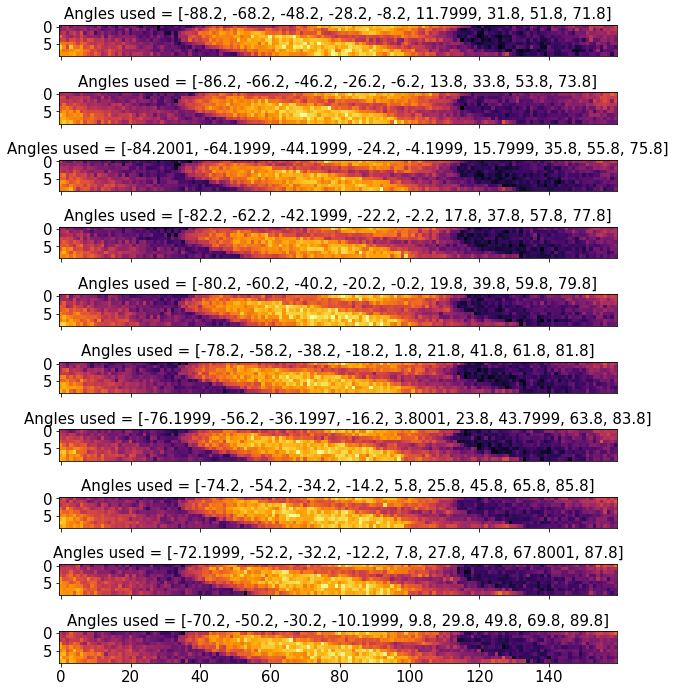

In [13]:
slice_ind = 50

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(10, 20)) 
grid = AxesGrid(fig, 111,
                nrows_ncols=(sequential_splitting.num_batches, 1),
                axes_pad=0.5
                )
k = 0
for ax in grid:    
    ax.imshow(list_ad_chunks_seq_split[k].array[slice_ind], cmap="inferno")
    ax.set_title("Angles used = {}".format(list(list_ad_chunks_seq_split[k].geometry.angles)),fontsize=15)    
    k+=1    
plt.show()


### RandomSampling

- For AcquisitionData with `len(ag.angles)` we can split it randomly into chunks/subsets without replacement and `batch_size`.


In [14]:
batch_size = 10
random_splitting = RandomSampling(num_angles, batch_size=batch_size, replace=False, seed=20)

print("Number of chunks/subsets = {}".format(random_splitting.num_batches))

for i,k in enumerate(random_splitting.partition_list):
    print("Chunk {} : {}\n".format(i,k))
    
list_ad_chunks_rand_split = data.split_to_chunks(random_splitting)

for i,k in enumerate(list_ad_chunks_rand_split):
    print("Chunk {} : Angles used = {}\n".format(i,list(k.geometry.angles)))


Number of chunks/subsets = 9
Chunk 0 : [84 36 43  5 35 68 64 82 37 48]

Chunk 1 : [ 3  6 33 53 44 67 81 65 74 88]

Chunk 2 : [54 70 62  9 26 47 24 56 52 29]

Chunk 3 : [11 61 89 18 83  0 15 66 86 42]

Chunk 4 : [78 45 19 87 16  7 60 13 58 30]

Chunk 5 : [50 46 32 49 27 57 10 20 25 31]

Chunk 6 : [77 12 71 76 51  4 73 39 63 22]

Chunk 7 : [69 17 14  2  1 79 85 34 21 23]

Chunk 8 : [72 80 28  8 75 59 40 55 41 38]

Chunk 0 : Angles used = [79.8, -16.2, -2.2, -78.2, -18.2, 47.8, 39.8, 75.8, -14.2, 7.8]

Chunk 1 : Angles used = [-82.2, -76.1999, -22.2, 17.8, -0.2, 45.8, 73.8, 41.8, 59.8, 87.8]

Chunk 2 : Angles used = [19.8, 51.8, 35.8, -70.2, -36.1997, 5.8, -40.2, 23.8, 15.7999, -30.2]

Chunk 3 : Angles used = [-66.2, 33.8, 89.8, -52.2, 77.8, -88.2, -58.2, 43.7999, 83.8, -4.1999]

Chunk 4 : Angles used = [67.8001, 1.8, -50.2, 85.8, -56.2, -74.2, 31.8, -62.2, 27.8, -28.2]

Chunk 5 : Angles used = [11.7999, 3.8001, -24.2, 9.8, -34.2, 25.8, -68.2, -48.2, -38.2, -26.2]

Chunk 6 : Angles used =

### Show chunks

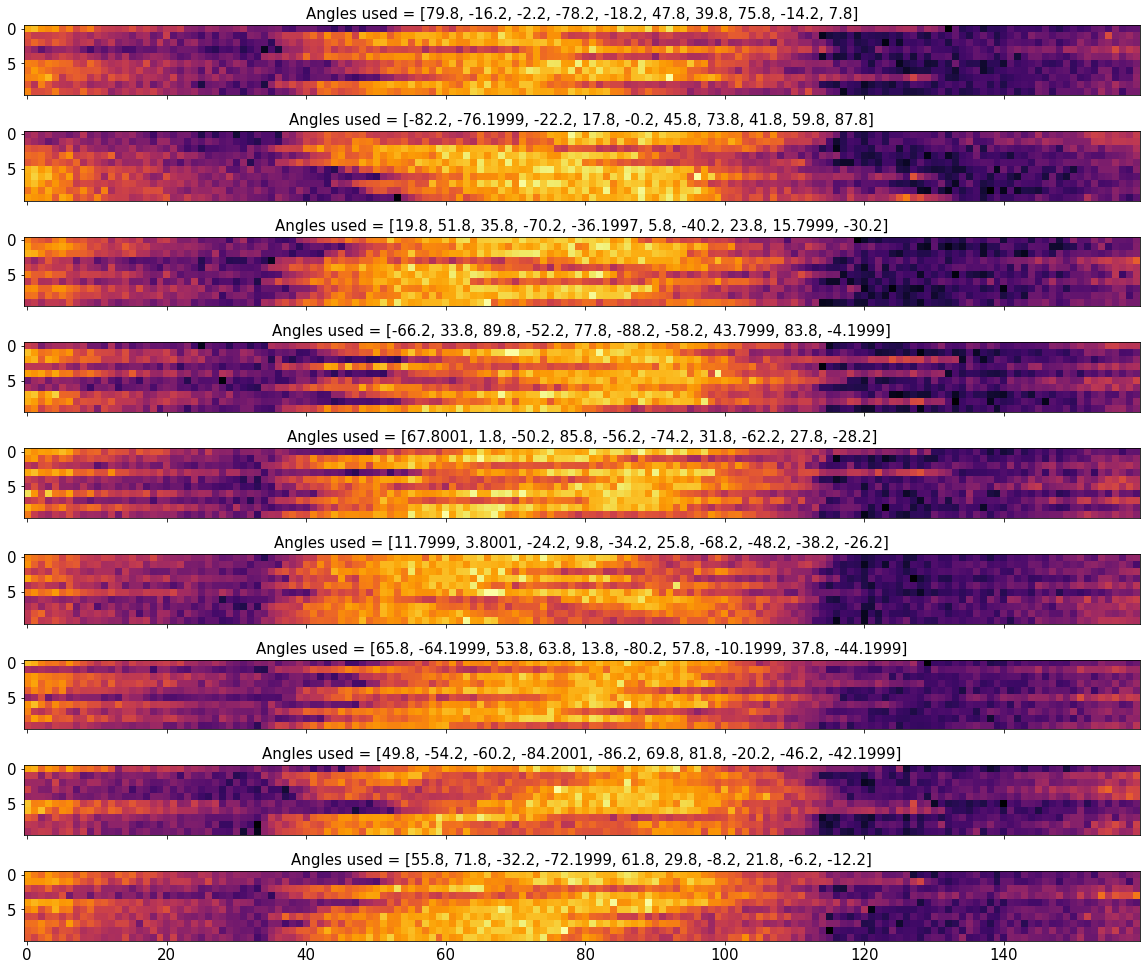

In [15]:
slice_ind = 50

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 20)) 
grid = AxesGrid(fig, 111,
                nrows_ncols=(random_splitting.num_batches, 1),
                axes_pad=0.5
                )
k = 0
for ax in grid:    
    ax.imshow(list_ad_chunks_rand_split[k].array[slice_ind], cmap="inferno")
    ax.set_title("Angles used = {}".format(list(list_ad_chunks_rand_split[k].geometry.angles)),fontsize=15)    
    k+=1    
plt.show()
